In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/path/to/diabetes.csv')
df.head()

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/path/to/diabetes.csv'

In [4]:
import zipfile
import os

# Define the path to the uploaded zip file
zip_path = '/content/diabetes.csv.zip'

# Define the directory where you want to extract the contents
extract_path = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now, the CSV file should be available in the extract_path
# You can then read the CSV file into a pandas DataFrame
csv_file_path = os.path.join(extract_path, 'diabetes.csv') # Assuming the csv file is named diabetes.csv inside the zip
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(df.columns.tolist())
df.info()
print("\nMissing values per column:\n", df.isnull().sum())
df.describe().T

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure             

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
df_clean = df.copy()

# 1) Replace zeros in key features with column median (change to mean if you prefer)
features_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
features_present = [c for c in features_with_zeros if c in df_clean.columns]

for col in features_present:
    df_clean[col] = df_clean[col].replace(0, np.nan)
    fill_value = df_clean[col].median()   # or df_clean[col].mean()
    df_clean[col].fillna(fill_value, inplace=True)

# 2) First row's glucose -> maximum glucose of the (already imputed) column
if 'Glucose' in df_clean.columns:
    df_clean.at[df_clean.index[0], 'Glucose'] = df_clean['Glucose'].max()

# 3) All rows with lowest Age -> their Glucose becomes the column minimum
if 'Age' in df_clean.columns and 'Glucose' in df_clean.columns:
    min_age = df_clean['Age'].min()
    min_glucose = df_clean['Glucose'].min()
    df_clean.loc[df_clean['Age'] == min_age, 'Glucose'] = min_glucose

# sanity checks
df_clean.describe().T

/tmp/ipython-input-4052035242.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(fill_value, inplace=True)


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,116.294271,36.797403,44.000,95.00000,115.0000,140.00000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
X = df_clean.drop(columns=['Outcome'])
y = df_clean['Outcome'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Continuous predictions from Linear Regression
y_pred_cont = lr.predict(X_test)

# Round to 0 or 1 as required, and clip just in case
y_pred = np.rint(y_pred_cont).clip(0, 1).astype(int)

print("Some raw predictions:", y_pred_cont[:5])
print("Rounded predictions:", y_pred[:5])

Some raw predictions: [0.5090318  0.23103509 0.40878022 0.33361852 0.05067392]
Rounded predictions: [1 0 0 0 0]


Accuracy : 0.7208
Precision: 0.6222
Recall   : 0.5185
F1-score : 0.5657

Classification report:
               precision    recall  f1-score   support

           0      0.761     0.830     0.794       100
           1      0.622     0.519     0.566        54

    accuracy                          0.721       154
   macro avg      0.692     0.674     0.680       154
weighted avg      0.713     0.721     0.714       154



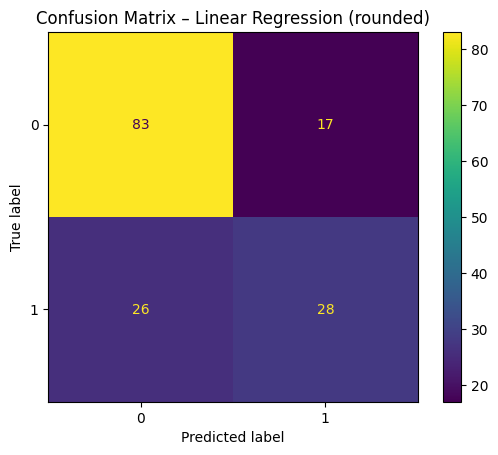

In [9]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot(values_format='d')
plt.title("Confusion Matrix – Linear Regression (rounded)")
plt.show()

Saved: diabetes_cleaned.csv, metrics.txt, confusion_matrix.png


<Figure size 640x480 with 0 Axes>

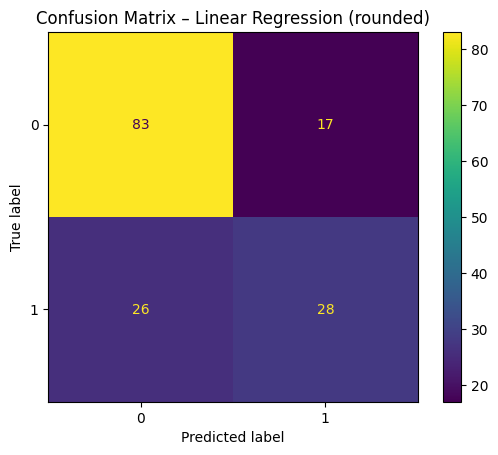

In [10]:
# Save cleaned data, metrics, and confusion matrix image
df_clean.to_csv('diabetes_cleaned.csv', index=False)

with open('metrics.txt','w') as f:
    f.write(f"Accuracy:  {acc:.4f}\n")
    f.write(f"Precision: {prec:.4f}\n")
    f.write(f"Recall:    {rec:.4f}\n")
    f.write(f"F1-score:  {f1:.4f}\n")

plt.figure()
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(values_format='d')
plt.title("Confusion Matrix – Linear Regression (rounded)")
plt.savefig('confusion_matrix.png', bbox_inches='tight')

# Download to your machine (optional)
from google.colab import files
# files.download('diabetes_cleaned.csv')
# files.download('metrics.txt')
# files.download('confusion_matrix.png')
print("Saved: diabetes_cleaned.csv, metrics.txt, confusion_matrix.png")